In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [95]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2022-01-01').date()



In [96]:
def categorize_change(diff):
    # Replace this function with your logic for categorizing changes
    return diff

def categorize_change(x):
    if pd.isnull(x):
        return None  # For the first day
    elif x > 0:
        return 1
    else:
        return 0

def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}

    for symbol in stock_symbols:
        # Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")

        # Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        
        rename_mapping = {'weighted positive sentiment score': 'Positive',
                          'weighted negative sentiment score': 'Negative',
                          'weighted neutral sentiment score': 'Neutral',
                          'weighted compound sentiment score': 'Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping)
        # Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]

        # Align by common dates
        common_dates = sentiment_filtered['Date'][sentiment_filtered['Date'].isin(stock_filtered['Date'])]
        sentiment_aligned = sentiment_filtered[sentiment_filtered['Date'].isin(common_dates)]
        stock_aligned = stock_filtered[stock_filtered['Date'].isin(common_dates)]

        # Merge and add features
        full_data = pd.concat([stock_aligned.reset_index(drop=True), sentiment_aligned.reset_index(drop=True)], axis=1)
        # Compute SMA and Price difference
        full_data['SMA'] = full_data['Close'].rolling(window= interval).mean()
        # full_data['SMA'] = full_data['Close'].iloc[i:i + interval].mean()

        full_data['Difference'] = full_data['Close'].diff()
        full_data['Trend'] = full_data['Close'].diff().apply(categorize_change)

        X_features_ = full_data.keys() 
        merged_data[symbol] = full_data.dropna()  # Drop NA after adding features
    
    return merged_data, X_features_




In [97]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)

print(Xfeatures)

Features = ['Volume', 'Positive', 'Negative', 'Neutral', 'Sentiment']
Targets = ['SMA', 'Difference', 'Close']

print(type(stock_data['GOOG']))
print(stock_data['GOOG'].shape)



Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Date', 'Ticker', 'Positive', 'Negative', 'Neutral',
       'Sentiment', 'SMA', 'Difference'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
(629, 16)


In [108]:
stock_data['MSFT']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,Ticker,Positive,Negative,Neutral,Sentiment,SMA,Difference
13,2012-04-19,24.771066,25.208718,24.619878,24.675579,54781200,0.0,0.0,2012-04-19,MSFT,0.127213,0.065286,0.810508,0.487605,24.511567,0.023874
14,2012-04-20,25.582713,26.171552,25.503139,25.797558,106045000,0.0,0.0,2012-04-20,MSFT,0.191000,0.000000,0.809000,0.880300,24.791268,1.121979
15,2012-05-03,25.367866,25.383781,25.153020,25.272379,31501300,0.0,0.0,2012-05-03,MSFT,0.144216,0.051000,0.844725,0.603767,25.008611,-0.525179
16,2012-05-04,25.025699,25.121185,24.603961,24.651705,57927200,0.0,0.0,2012-05-04,MSFT,0.149000,0.000000,0.851000,0.758100,25.031984,-0.620674
17,2012-05-23,23.507915,23.547962,22.939239,23.315687,65171000,0.0,0.0,2012-05-23,MSFT,0.000000,0.075000,0.925000,-0.510600,24.975174,-1.336018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,2021-12-21,315.748190,320.084615,312.339586,319.654877,24740600,0.0,0.0,2021-12-21,MSFT,0.000000,0.176000,0.824000,-0.128000,322.004456,7.207825
662,2021-12-22,320.641287,325.827411,318.150786,325.427002,24831500,0.0,0.0,2021-12-22,MSFT,0.229551,0.000000,0.861543,0.367490,322.186534,5.772125
663,2021-12-27,327.634197,334.490450,327.604898,334.461151,19947000,0.0,0.0,2021-12-27,MSFT,0.089000,0.132000,0.902859,-0.140600,323.049491,9.034149
664,2021-12-28,335.144916,335.789523,332.380948,333.289246,15661500,0.0,0.0,2021-12-28,MSFT,0.353000,0.000000,0.937376,0.612600,323.869899,-1.171906


In [99]:
# g = sns.pairplot(stock_data['GOOG'], x_vars=Features, y_vars=Targets)
# names = df.columns.map(lambda t: t.split('(')[0])
# for i in range(8):
#     g.axes[0,i].xaxis.set_label_text(names[i])
#     g.axes[0,i].yaxis.set_label_text(names[8])
# plt.show()
# # plt.show()

In [100]:
# plt.scatter(stock_data['GOOG']['weighted compound sentiment score'], stock_data['GOOG']['Price Difference'])

In [107]:
def train_predict(data, features, target):
    results = {}

    for ticker, df in data.items():
        # Prepare data
        X = df[features]
        y = df[target]

        # Train-test split
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        split_index = int(len(df) * 0.85)
        print(len(df), split_index)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]

        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        # Train XGBoost Model
        model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred) 
        print(f"{ticker} - MSE: {mse:.4f}, MAE: {mae:.4f}")

        # Store Results
        results[ticker] = {
            'model': model,
            'mse': mse,
            'mae': mae,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results

def plot_predictions(results, target):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target})')
        plt.legend()
        plt.show()



In [105]:
results = []

for target in Targets:
    print(target)
    res = train_predict(stock_data, Features, target)
    
    results.append(res)

SMA
GOOG - MSE: 3140.5048, MAE: 53.6192
MSFT - MSE: 14954.7727, MAE: 110.9202
NVDA - MSE: 190.1303, MAE: 12.5798
AMZN - MSE: 1999.3173, MAE: 35.7963
AAPL - MSE: 1912.6126, MAE: 36.5399
Difference
GOOG - MSE: 4.0052, MAE: 1.5189
MSFT - MSE: 31.7227, MAE: 3.8335
NVDA - MSE: 0.6833, MAE: 0.6121
AMZN - MSE: 6.6206, MAE: 1.9745
AAPL - MSE: 5.4272, MAE: 1.7718
Close
GOOG - MSE: 3037.9064, MAE: 53.0236
MSFT - MSE: 14030.9226, MAE: 107.5534
NVDA - MSE: 203.6383, MAE: 13.0188
AMZN - MSE: 1886.5388, MAE: 35.1856
AAPL - MSE: 1952.2546, MAE: 37.0495


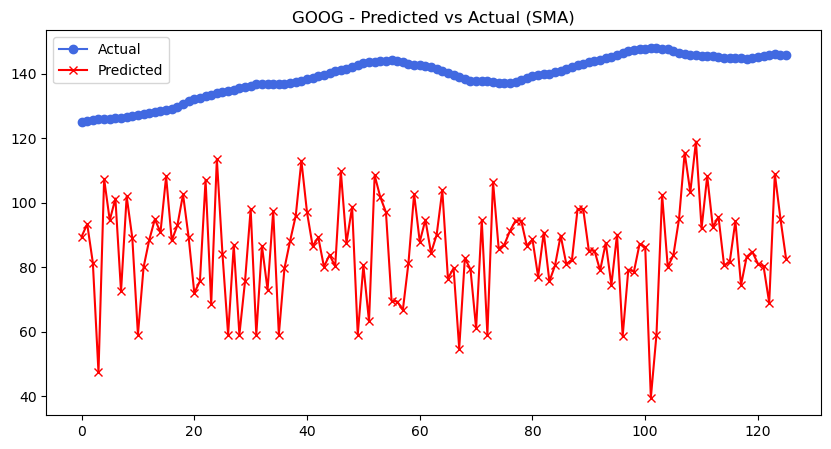

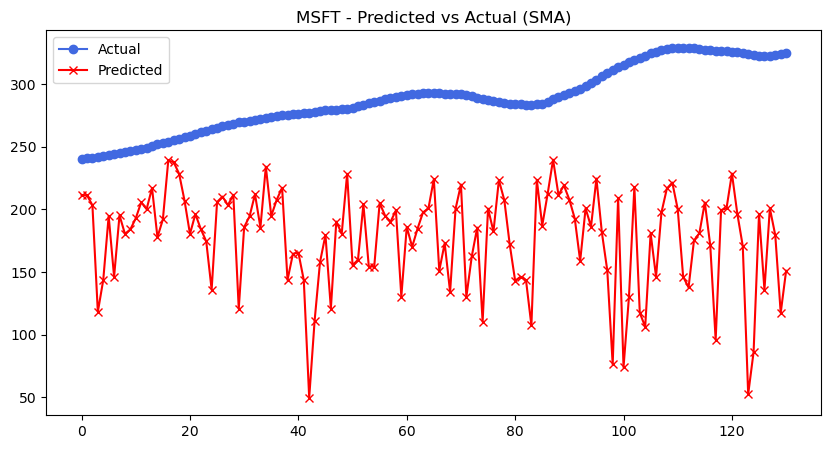

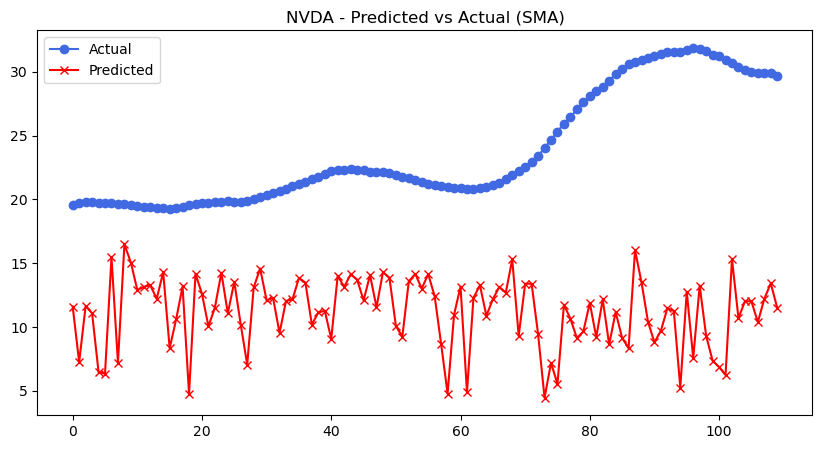

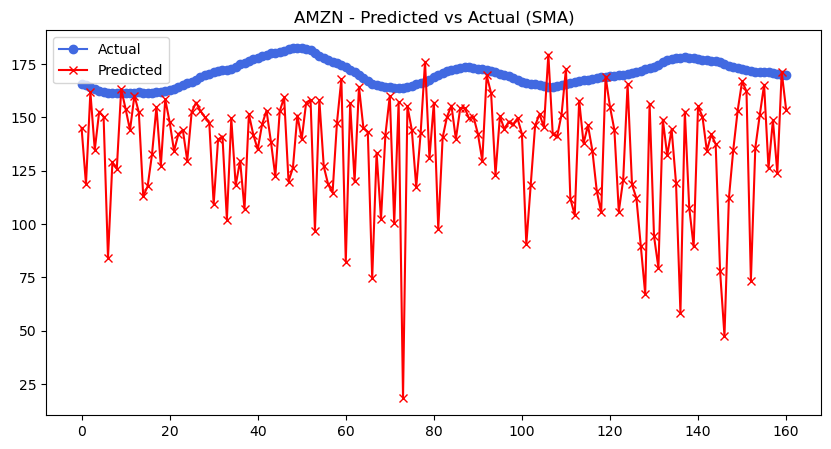

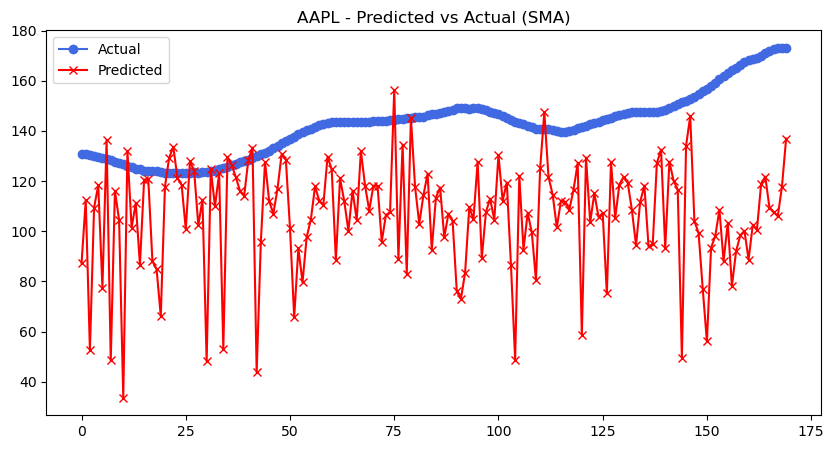

In [106]:
k = 0
plot_predictions(results[k], Targets[k])